<a href="https://colab.research.google.com/github/kurtsenol/machine-learning/blob/master/TopicModeling/LDA_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import pickle

In [ ]:
df = pd.read_pickle("drive/My Drive/Topic_Modeling/topic_df.pkl")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df

,Title,Journal,Year,Abstract
0,TWO-DIRECTIONAL CONVERGENCE OF PLATFORM AND PI...,JOURNAL OF SERVICE MANAGEMENT,NaN,PURPOSE THIS ARTICLE EXAMINES THE NEW PHENOMEN...
1,EMPLOYEE WELLNESS ON THE FRONTLINE: AN INTERAC...,JOURNAL OF SERVICE MANAGEMENT,NaN,PURPOSE EMPLOYEE WELLNESS IS VITAL TO CREATING...
2,DEMOGRAPHIC AND ATTITUDINAL ANTECEDENTS OF CON...,JOURNAL OF SERVICE MANAGEMENT,NaN,PURPOSE TO INVESTIGATE IF ONLINE TV CONTENT PL...
3,MORE THAN A FEELING? TOWARD A THEORY OF CUSTOM...,JOURNAL OF SERVICE MANAGEMENT,NaN,PURPOSE RESPONDING TO AN INCREASING CALL FOR A...
4,ACCOUNTABLE ALGORITHMS? THE ETHICAL IMPLICATIO...,JOURNAL OF SERVICE MANAGEMENT,NaN,PURPOSE THE PURPOSE OF THIS STUDY IS TO IDENTI...
...,...,...,...,...
10869,A COMMENTARY ON THE CASE STUDY OF STATE-OWNED ...,CORNELL HOSPITALITY QUARTERLY,2011.0,THE COMPARISON OF STEPHEN RUSHMORE'S SEVEN HOT...
10870,COMMENTARY ON A CASE STUDY OF STATE-OWNED HOTE...,CORNELL HOSPITALITY QUARTERLY,2011.0,THE RECENT LIQUIDITY CRISIS IN THE GLOBAL HOTE...
10871,A MULTIDIMENSIONAL SCALE OF SWITCHING BARRIERS...,CORNELL HOSPITALITY QUARTERLY,2011.0,THIS RESEARCH ATTEMPTED TO DEVELOP A MEASUREME...
10872,A COMPARISON OF COLD-WATER THAWING OPTIONS IN ...,CORNELL HOSPITALITY QUARTERLY,2011.0,CONSIDERING ALL TYPES OF RESTAURANTS IN HONG K...


In [ ]:
df.groupby('Journal')['Abstract'].count()

Journal
ANNALS OF TOURISM RESEARCH                                       706
CORNELL HOSPITALITY QUARTERLY                                    331
CURRENT ISSUES IN TOURISM                                        944
INTERNATIONAL JOURNAL OF CONTEMPORARY HOSPITALITY MANAGEMENT    1037
INTERNATIONAL JOURNAL OF HOSPITALITY MANAGEMENT                 1372
INTERNATIONAL JOURNAL OF TOURISM RESEARCH                        552
JOURNAL OF HOSPITALITY AND TOURISM MANAGEMENT                    259
JOURNAL OF HOSPITALITY MARKETING & MANAGEMENT                    241
JOURNAL OF SERVICE MANAGEMENT                                    316
JOURNAL OF SUSTAINABLE TOURISM                                   746
JOURNAL OF TRAVEL & TOURISM MARKETING                            624
JOURNAL OF TRAVEL RESEARCH                                       686
JOURNAL OF VACATION MARKETING                                    177
RESEARCH IN TRANSPORTATION BUSINESS AND MANAGEMENT               195
SCANDINAVIAN JOURNAL OF HO

In [ ]:
papers = list(df.Abstract.values)

In [ ]:
len(papers)

10874

In [ ]:
print(papers[0][:1000])

PURPOSE THIS ARTICLE EXAMINES THE NEW PHENOMENON OF THE CONVERGENCE OF PLATFORM AND PIPELINE BUSINESS MODELS. IT EXAMINES THE POTENTIAL SYNERGIES AND CHALLENGES FOR PLATFORMS TO ADD PIPELINE COMPONENTS AND VICE VERSA FOR PIPELINE BUSINESSES. DESIGN/METHODOLOGY/APPROACH THIS PAPER USES A CONCEPTUAL APPROACH THAT SYNTHESIZES AND INTEGRATES THE LITERATURE FROM SERVICE, HOSPITALITY, AND STRATEGY, AND SUPPLEMENTS THEM WITH TWO ILLUSTRATIVE MINI-CASE STUDIES. FINDINGS WHILE THE EXTANT LITERATURE TYPICALLY FOCUSES ON THE DICHOTOMY BETWEEN INCUMBENT PIPELINE BUSINESSES THAT CREATE VALUE BY CONTROLLING A LINEAR SERIES OF ACTIVITIES AND NETWORK EFFECTS-DRIVEN PLATFORMS, WE DIFFERENTIATE BETWEEN TWO TYPES OF PLATFORM BUSINESS MODELS (I.E. PLATFORMS WITH ASSET CONTROL AND PLATFORMS WITH PEER-PROVIDED ASSETS). FURTHER, WE IDENTIFY THREE COMMON PATHWAYS OF CONVERGENCE; THAT IS, PIPELINES MOVING TOWARDS (1) PLATFORMS WITH ASSET CONTROL AND (2) THOSE WITH PEER-PROVIDED ASSETS, AND (3) PLATFORMS WITH P

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 1.3MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp36-none-any.whl size=829180944 sha256=7dfe0d66b6834acecc905b11290d9093b0185e6190f6e14cf4f51d465149b2f9
  Stored in directory: /tmp/pip-ephem-wheel-cache-mldwxp5s/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
import numpy as np
import pandas as pd

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_lg

from tqdm import tqdm_notebook as tqdm
from pprint import pprint

In [ ]:
nlp= spacy.load("en")

In [ ]:
def lemmatizer(doc):
    # This takes in a doc of tokens from the NER and lemmatizes them. 
    # Pronouns (like "I" and "you" get lemmatized to '-PRON-', so I'm removing those.
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)
    
def remove_stopwords(doc):
    # This will remove stopwords and punctuation.
    # Use token.text to return strings, which we'll need for Gensim.
    doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return doc

# The add_pipe function appends our functions to the default pipeline.
nlp.add_pipe(lemmatizer,name='lemmatizer',after='ner')
nlp.add_pipe(remove_stopwords, name="stopwords", last=True)

In [ ]:
doc_list = []

# Iterates through each article in the corpus.
for doc in tqdm(papers):
    # Passes that article through the pipeline and adds to a new list.
    pr = nlp(doc)
    doc_list.append(pr)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [ ]:
# Creates, which is a mapping of word IDs to words.
words = corpora.Dictionary(doc_list)

# Turns each document into a bag of words.
corpus = [words.doc2bow(doc) for doc in doc_list]

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=words,
                                           num_topics=10, 
                                           random_state=2,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
pprint(lda_model.print_topics(num_words=10))

[(0,
  '0.019*"value" + 0.018*"SERVICE" + 0.013*"study" + 0.013*"customer" + '
  '0.013*"CUSTOMER" + 0.011*"service" + 0.011*"use" + 0.011*"FINDINGS" + '
  '0.011*"model" + 0.010*"satisfaction"'),
 (1,
  '0.023*"brand" + 0.019*"consumer" + 0.015*"customer" + 0.012*"restaurant" + '
  '0.011*"SOCIAL" + 0.011*"STUDY" + 0.009*"online" + 0.009*"study" + '
  '0.009*"influence" + 0.008*"effect"'),
 (2,
  '0.060*"firm" + 0.024*"restaurant" + 0.020*"csr" + 0.018*"corporate" + '
  '0.011*"FINANCIAL" + 0.011*"CSR" + 0.008*"performance" + '
  '0.007*"RESPONSIBILITY" + 0.007*"FAMILY" + 0.007*"activity"'),
 (3,
  '0.034*"employee" + 0.013*"JOB" + 0.012*"relationship" + '
  '0.011*"ORGANIZATIONAL" + 0.011*"work" + 0.011*"STUDY" + 0.011*"HOSPITALITY" '
  '+ 0.010*"effect" + 0.010*"performance" + 0.009*"study"'),
 (4,
  '0.016*"TOURISM" + 0.011*"RESEARCH" + 0.011*"experience" + 0.008*"paper" + '
  '0.007*"STUDY" + 0.007*"study" + 0.007*"research" + 0.007*"use" + '
  '0.006*"travel" + 0.006*"TRAVEL"'),


In [ ]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=doc_list, dictionary=words, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.41907118114551317


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=words, corpus=corpus, texts=doc_list, start=2, limit=40, step=1)

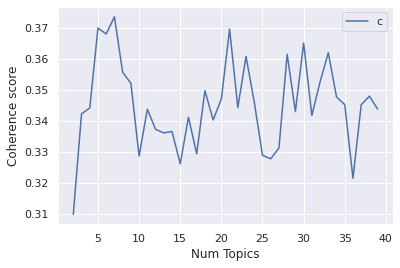

In [ ]:
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Source: https://towardsdatascience.com/building-a-topic-modeling-pipeline-with-spacy-and-gensim-c5dc03ffc619